In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import sys
import datetime

import pyvips as pv
import cv2
from sklearn.model_selection import StratifiedKFold

import warnings; warnings.filterwarnings('ignore')

sys.path.append('..')
from config import CFG
CFG = CFG()
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', CFG.NCOLS)
pd.set_option('display.max_rows', CFG.NROWS)

In [14]:
train_meta = pd.read_csv(f'{CFG.DATA_PATH}/train_metadata.csv')
train_labels = pd.read_csv(f'{CFG.DATA_PATH}/train_labels.csv')
train = train_meta.merge(train_labels, on='filename')

In [15]:
train = train.sort_values('tif_size').reset_index(drop=True)
train1 = train.iloc[:len(train)//2].reset_index(drop=True)
train2 = train.iloc[~train1.index].reset_index(drop=True)
train = pd.concat([train1, train2]).sort_index().reset_index(drop=True)

In [16]:
train['age'] = train['age'].apply(lambda x: x[1:3]).astype(int)
train['age'] = train['age'] / train['age'].max()
train["melanoma_history"] = train["melanoma_history"].replace({'YES': 1, 'NO': 0}).fillna(-1).astype(int)
train['sex'] = train['sex'].replace({1: 0}).replace({2: 1}).astype(int)
train = train.drop(['body_site', 'breslow', 'ulceration'], axis=1)

In [17]:
train.to_csv(f'{CFG.DATA_PATH}/train.csv', index=False)

In [18]:
pd.read_csv(f'{CFG.DATA_PATH}/train.csv')

,filename,age,sex,melanoma_history,tif_cksum,tif_size,us_tif_url,eu_tif_url,as_tif_url,local_url,relapse
0,w6uejlue.tif,0.63,1,-1,80756657,27465352,s3://drivendata-competition-visiomel-public-us...,s3://drivendata-competition-visiomel-public-eu...,s3://drivendata-competition-visiomel-public-as...,s3://visiomel/originals/w6uejlue.tif,0
1,tdb0zem7.tif,0.84,0,0,765200221,4198582882,s3://drivendata-competition-visiomel-public-us...,s3://drivendata-competition-visiomel-public-eu...,s3://drivendata-competition-visiomel-public-as...,s3://visiomel/originals/tdb0zem7.tif,0
2,rr2jx9as.tif,0.22,0,0,2085341479,4175597278,s3://drivendata-competition-visiomel-public-us...,s3://drivendata-competition-visiomel-public-eu...,s3://drivendata-competition-visiomel-public-as...,s3://visiomel/originals/rr2jx9as.tif,0
3,dhaohj9d.tif,0.92,1,-1,15925452,32159712,s3://drivendata-competition-visiomel-public-us...,s3://drivendata-competition-visiomel-public-eu...,s3://drivendata-competition-visiomel-public-as...,s3://visiomel/originals/dhaohj9d.tif,0
4,k85cemwe.tif,0.80,1,-1,2376188009,33070516,s3://drivendata-competition-visiomel-public-us...,s3://drivendata-competition-visiomel-public-eu...,s3://drivendata-competition-visiomel-public-as...,s3://visiomel/originals/k85cemwe.tif,0
...,...,...,...,...,...,...,...,...,...,...,...
1337,8qmf9gy2.tif,0.71,1,-1,1829984772,1109290536,s3://drivendata-competition-visiomel-public-us...,s3://drivendata-competition-visiomel-public-eu...,s3://drivendata-competition-visiomel-public-as...,s3://visiomel/originals/8qmf9gy2.tif,0
1338,z5qdks0z.tif,0.73,0,-1,65562899,1114666882,s3://drivendata-competition-visiomel-public-us...,s3://drivendata-competition-visiomel-public-eu...,s3://drivendata-competition-visiomel-public-as...,s3://visiomel/originals/z5qdks0z.tif,0
1339,ai561bat.tif,0.76,1,-1,930052501,1109636664,s3://drivendata-competition-visiomel-public-us...,s3://drivendata-competition-visiomel-public-eu...,s3://drivendata-competition-visiomel-public-as...,s3://visiomel/originals/ai561bat.tif,0
1340,47ne6ap5.tif,0.27,1,1,2325526589,1110040652,s3://drivendata-competition-visiomel-public-us...,s3://drivendata-competition-visiomel-public-eu...,s3://drivendata-competition-visiomel-public-as...,s3://visiomel/originals/47ne6ap5.tif,0


In [13]:
img = pv.Image.new_from_file('../kyk203jv.tif', access='sequential', page=6)

In [14]:
img.height, img.width

(6356, 2776)

In [15]:
_, s, _  = cv2.split(cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2HSV))
#cv2. 's', s)

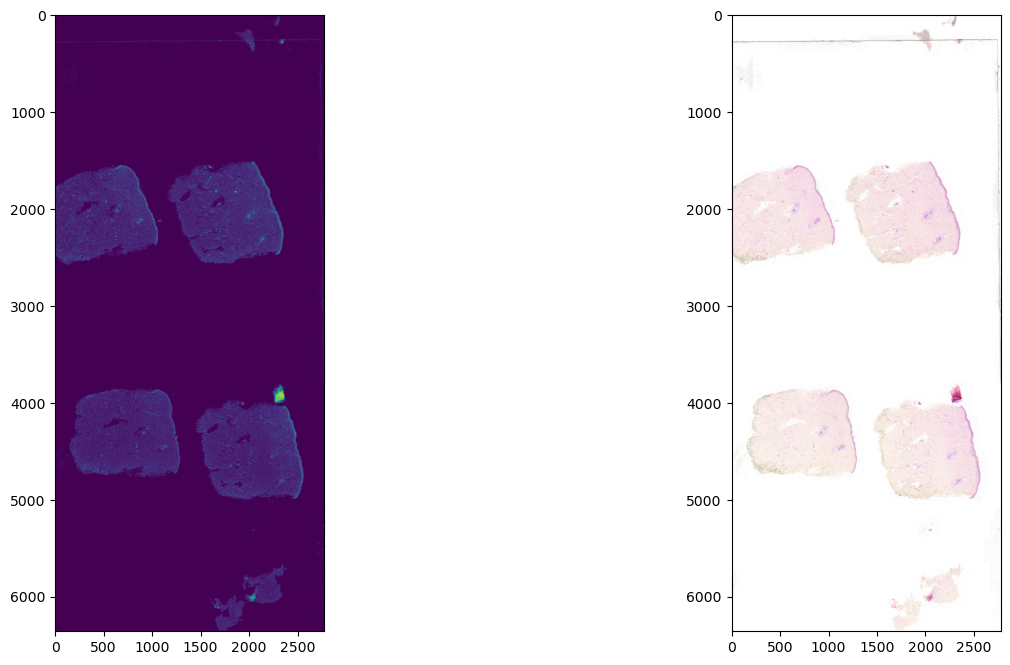

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(s)
axes[1].imshow(img)

In [26]:
print(np.min(s[1000, :]), np.max(s[1000, :]))
print(np.min(s[4000, :]), np.max(s[4000, :]))

0 27
0 111


In [36]:
flags = [i for i in dir(cv2) if i.startswith('COLOR_')]
print( [flag for flag in flags if 'HSV' in flag])

['COLOR_BGR2HSV', 'COLOR_BGR2HSV_FULL', 'COLOR_HSV2BGR', 'COLOR_HSV2BGR_FULL', 'COLOR_HSV2RGB', 'COLOR_HSV2RGB_FULL', 'COLOR_RGB2HSV', 'COLOR_RGB2HSV_FULL']


In [1]:
import torch
torch.cuda.current_device()

0

In [10]:
def split_df(df, args):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    df["fold"] = -1
    fold_idx = len(df.columns) - 1

    y = df[args['labels']]
    for i, (_, dev_index) in enumerate(kf.split(range(len(df)), y.values)):
        df.iloc[dev_index, fold_idx] = i

    return (
        df[df.fold != args['fold']].reset_index(drop=True),
        df[df.fold == args['fold']].reset_index(drop=True),
    )

In [ ]:
args = {'labels': 'relapse', 'fold': 1}
train, valid = split_df(train, args)

In [ ]:
def read_img(path, page=4):
    slide = pv.Image.new_from_file(str(path), page=page)
    region = pv.Region.new(slide).fetch(0, 0, slide.width, slide.height)

    return np.ndarray(
        buffer=region, dtype=np.uint8, shape=(slide.height, slide.width, 3)
    )

def get_tiles(img, tile_size=256, n_tiles=36, mode=0):
    h, w, c = img.shape
    pad_h = (tile_size - h % tile_size) % tile_size + ((tile_size * mode) // 2)
    pad_w = (tile_size - w % tile_size) % tile_size + ((tile_size * mode) // 2)

    img = np.pad(
        img,
        [[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2, pad_w - pad_w // 2], [0, 0]],
        constant_values=255,
    )
    img = img.reshape(
        img.shape[0] // tile_size, tile_size, img.shape[1] // tile_size, tile_size, 3
    )
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, tile_size, tile_size, 3)

    n_tiles_with_info = (
        img.reshape(img.shape[0], -1).sum(1) < tile_size ** 2 * 3 * 255
    ).sum()
    if len(img) < n_tiles:
        img = np.pad(
            img, [[0, n_tiles - len(img)], [0, 0], [0, 0], [0, 0]], constant_values=255
        )

    idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))[:n_tiles]
    img = img[idxs]

    return img, n_tiles_with_info >= n_tiles

def get_filenames(df):
    df['filename'] = df['filename'].apply(lambda x: f'{CFG.DATA_PATH}/originals/{x}')
    return df

def concat_tiles(tiles, n_tiles, image_size, rand=False, transform=None):
    if rand:
        idxes = np.random.choice(list(range(n_tiles)), n_tiles, replace=False)
    else:
        idxes = list(range(n_tiles))

    n_row_tiles = int(np.sqrt(n_tiles))
    img = np.zeros(
        (image_size * n_row_tiles, image_size * n_row_tiles, 3), dtype="uint8"
    )
    for h in range(n_row_tiles):
        for w in range(n_row_tiles):
            i = h * n_row_tiles + w

            if len(tiles) > idxes[i]:
                this_img = tiles[idxes[i]]
            else:
                this_img = np.ones((image_size, image_size, 3), dtype="uint8") * 255

            if transform is not None:
                this_img = transform(this_img)

            h1 = h * image_size
            w1 = w * image_size
            img[h1 : h1 + image_size, w1 : w1 + image_size] = this_img

    if transform is not None:
        img = transform(img)

    return img

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

In [ ]:
# train = get_filenames(train)
#row = train.iloc[0]
img = read_img(train.loc[2, 'filename'])
img, _ = get_tiles(
    img,
    # tile_size=self.config.train.tile_size,
    # n_tiles=self.config.train.n_tiles,
    mode=0,
)
img = concat_tiles(
    img,
    n_tiles=36,
    image_size=256,
    # rand=self.is_train,
    # transform=self.transform,
)

In [ ]:
img.shape

(1536, 1536, 3)

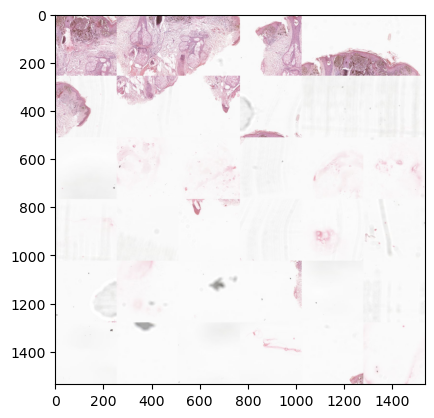

In [ ]:
plt.imshow(img)

In [ ]:
import torch

0.2221197776777555 0.1712991778015937


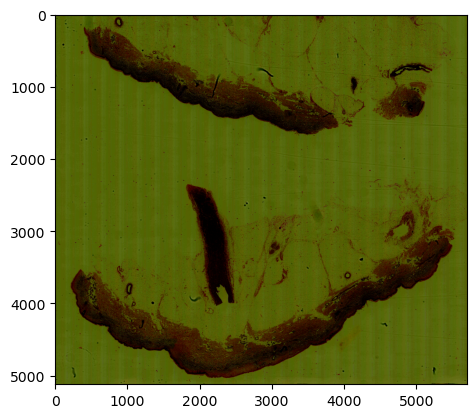

In [ ]:
img = pv.Image.new_from_file(train.loc[5, 'filename'], page=4)
img = np.asarray(img) /255
img = (img - CFG.MUMEAN) / CFG.STDMEAN
img = np.clip(img, -1., 1.)
img = (img + 1) / 2

print(np.mean(img), np.std(img))
plt.imshow(img)